In [2]:
import os
import re
import sys
import glob
import uproot
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats as st
import scipy

import peakutils

from datetime import datetime

import math
from scipy          import stats
from scipy.optimize import curve_fit

from matplotlib.colors import LogNorm

In [3]:
### Import functions from peak_functions

repository_path = os.path.abspath('../..')
sys.path.append(repository_path)

import blr_functions  as blr
import peak_functions as pf
import fit_functions  as fitf

In [4]:
### Import fit functions from IC
repository_path = os.path.abspath('/Users/romoluque_c/Repositories/IC/')
sys.path.append(repository_path)

import invisible_cities.core.fit_functions as fitf2

In [5]:
import matplotlib

# Set Palatino as the serif font
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif']  = 'Palatino'

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
plt.rcParams["figure.figsize"] = 7.5, 4.5
plt.rcParams["font.size"]      = 12

In [8]:
fav_col = '#418094'

In [9]:
def extract_date_obj_and_number(filename):
    match       = re.search(r"(\d{2}_\d{2}_\d{4})-file_(\d+)", filename)
    date_str    = match.group(1)
    file_number = int(match.group(2))
    date_obj    = datetime.strptime(date_str, "%m_%d_%Y")
    return date_obj, file_number

def extract_date_and_number(filename):
    match = re.search(r"(\d{2}_\d{2}_\d{4})-file_(\d+)", filename)
    return match.group(1), int(match.group(2))


In [10]:
evts_path    = '/Users/romoluque_c/LEGEND/BACON/new_setup/data_npz_run3/'
files        = glob.glob(evts_path + 'BACoN_pmt_analysis_peaks_run-*.npz')
sorted_files = sorted(files, key=extract_date_obj_and_number)

h_peaks_pmt_dict = {}
i_peaks_pmt_dict = {}
l_peaks_pmt_dict = {}

all_chs = range(13)

for filename in sorted_files:
    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)
    
    if date not in h_peaks_pmt_dict:
        print(date)
        h_peaks_pmt_dict[date] = d['h_peaks_pmt']
        i_peaks_pmt_dict[date] = d['i_peaks_pmt']
        l_peaks_pmt_dict[date] = d['l_peaks_pmt']

    else:
        h_peaks_pmt_dict[date] = np.concatenate((h_peaks_pmt_dict[date], d['h_peaks_pmt']))
        i_peaks_pmt_dict[date] = np.concatenate((i_peaks_pmt_dict[date], d['i_peaks_pmt']))
        l_peaks_pmt_dict[date] = np.concatenate((l_peaks_pmt_dict[date], d['l_peaks_pmt']))

09_10_2024
09_11_2024
09_12_2024
09_20_2024
09_25_2024
09_28_2024
10_04_2024
10_11_2024
10_17_2024
10_25_2024
11_01_2024
11_11_2024
11_25_2024
12_13_2024
12_21_2024
01_02_2025
01_10_2025
01_19_2025


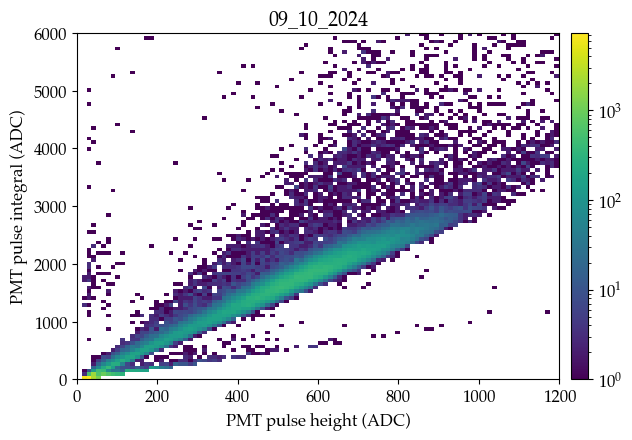

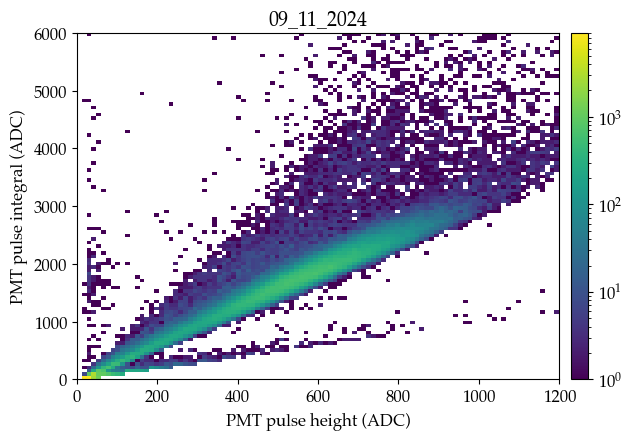

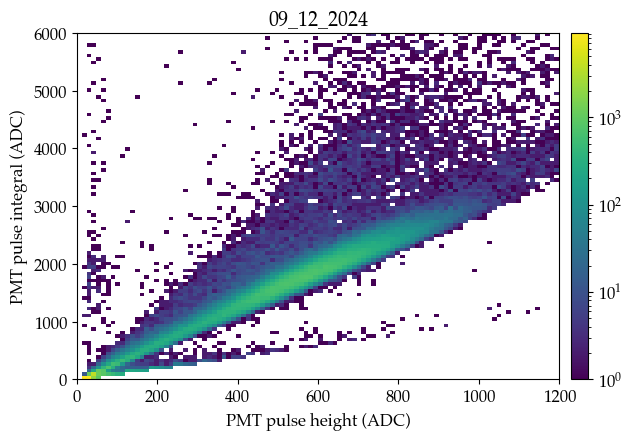

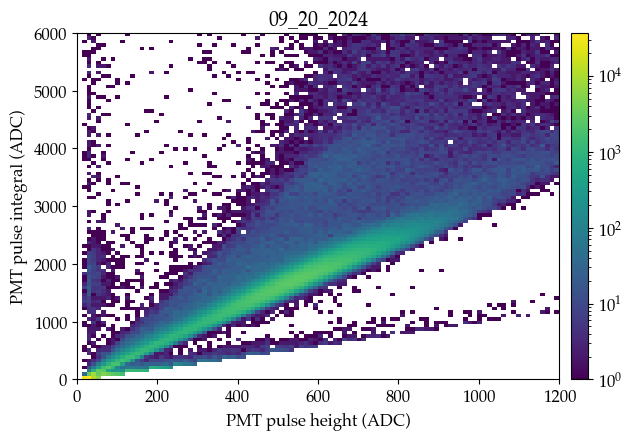

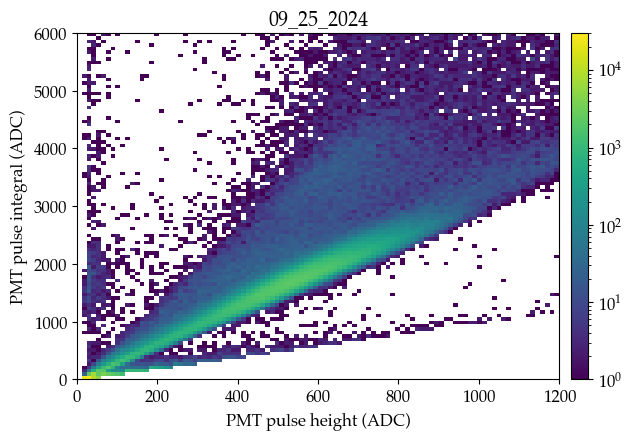

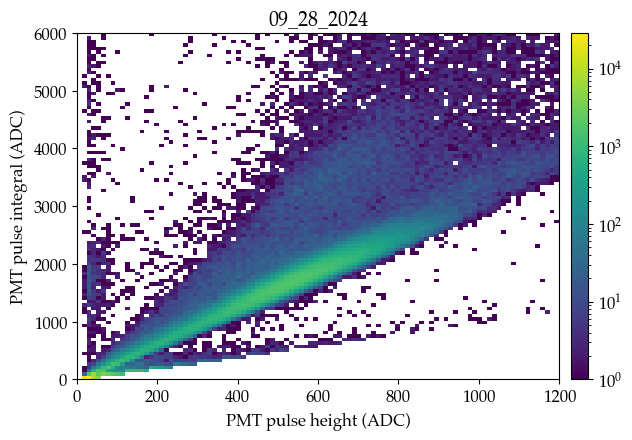

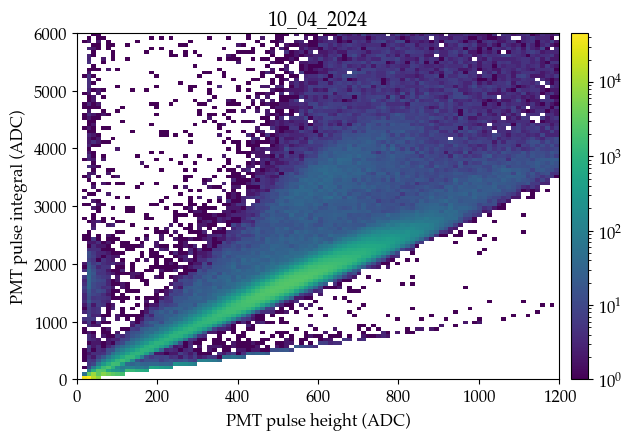

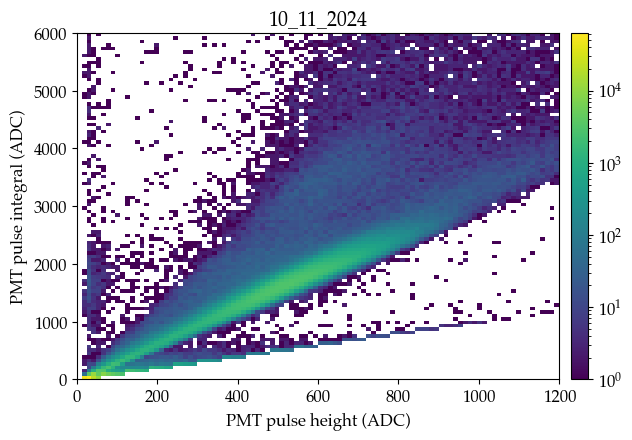

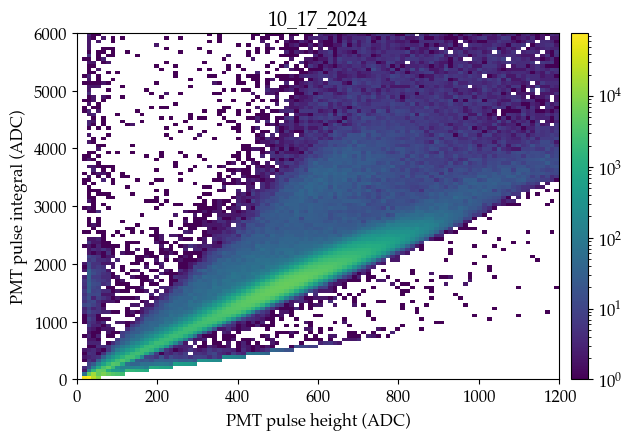

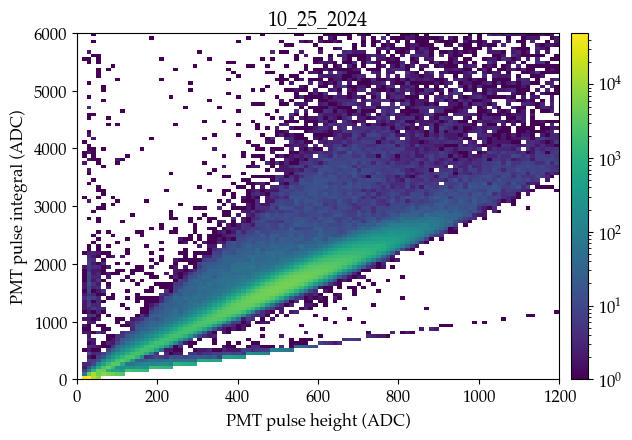

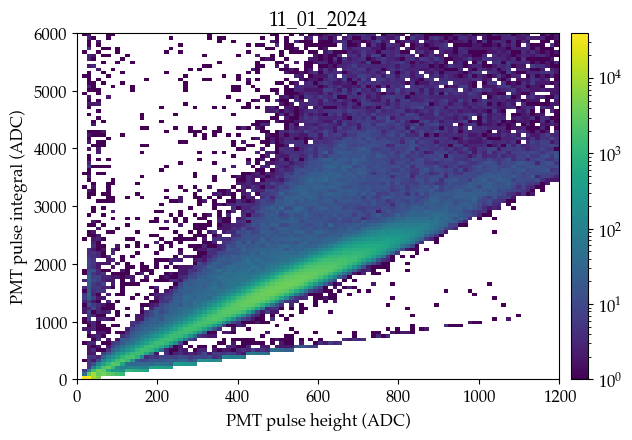

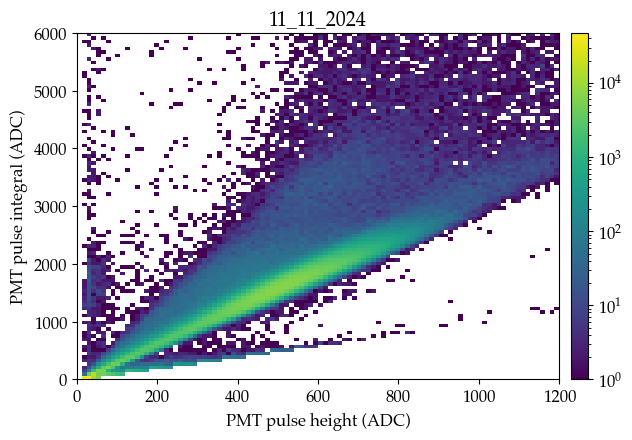

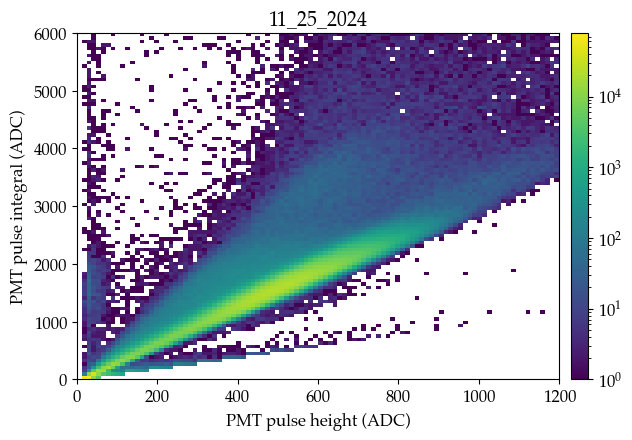

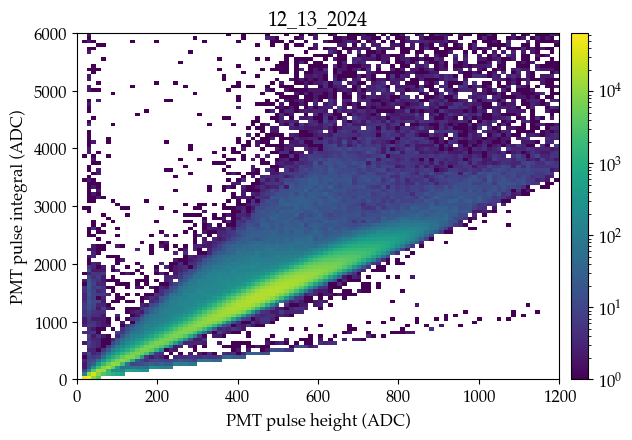

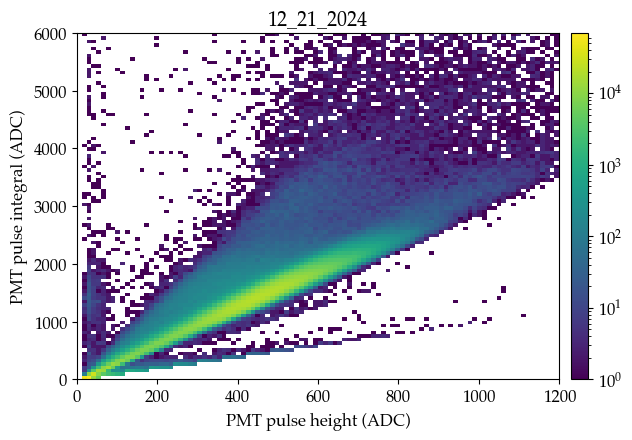

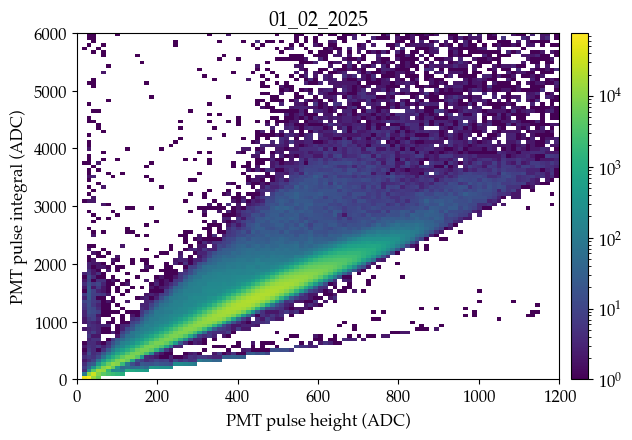

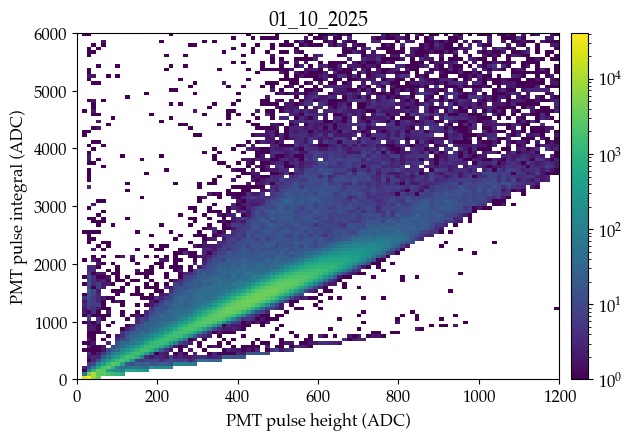

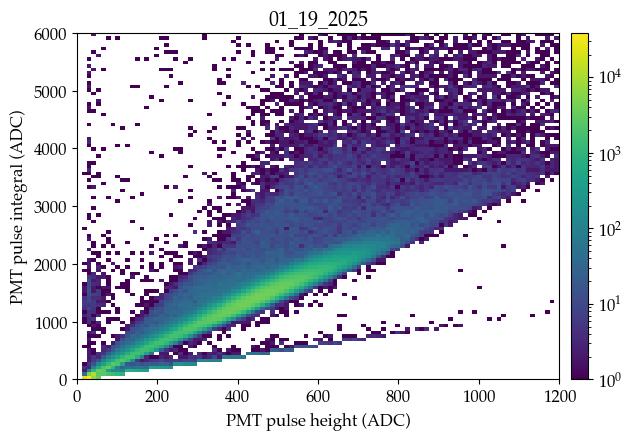

In [11]:
for date in h_peaks_pmt_dict.keys():
    plt.hist2d(h_peaks_pmt_dict[date], i_peaks_pmt_dict[date], bins=(100, 100), range=((0, 1200), (0, 6000)), cmin=1, norm=LogNorm())
    plt.ylabel('PMT pulse integral (ADC)')
    plt.xlabel('PMT pulse height (ADC)')
    plt.title(f'{date}')
    plt.colorbar(pad=0.02)
    plt.show()

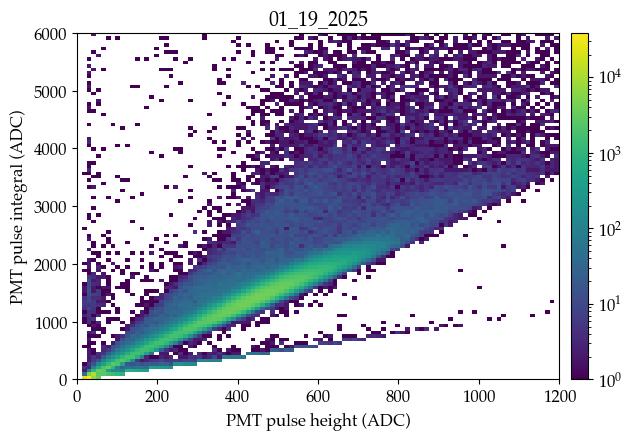

In [12]:
sel_date = '01_19_2025'
plt.hist2d(h_peaks_pmt_dict[sel_date], i_peaks_pmt_dict[sel_date], bins=(100, 100), range=((0, 1200), (0, 6000)), cmin=1, norm=LogNorm())
plt.ylabel('PMT pulse integral (ADC)')
plt.xlabel('PMT pulse height (ADC)')
plt.title(f'{date}')
plt.colorbar(pad=0.02)
plt.show()

In [13]:
x1 = 0
y1 = 400
x2 = 1200
y2 = 4500
slope = (y2 - y1)/(x2 - x1)
print(slope)
line_test  = h_peaks_pmt_dict[sel_date]*slope + 400
line_test2 = h_peaks_pmt_dict[sel_date]*slope - 600

3.4166666666666665


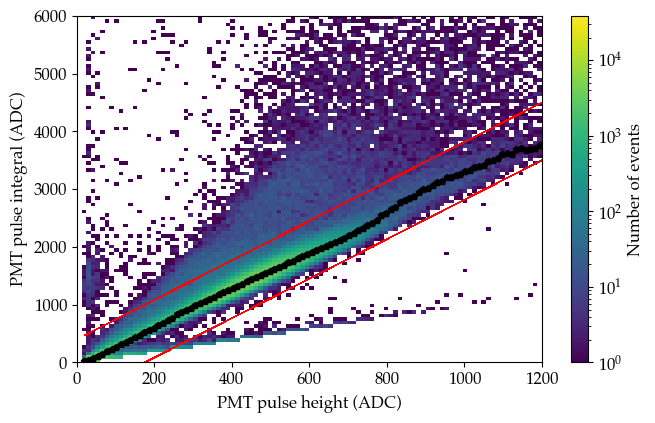

In [14]:
sel_lines = (i_peaks_pmt_dict[sel_date] < (line_test)) & (i_peaks_pmt_dict[sel_date] > (line_test2))
h_peaks   =  h_peaks_pmt_dict[sel_date][sel_lines]
i_peaks   =  i_peaks_pmt_dict[sel_date][sel_lines]
plt.hist2d(h_peaks_pmt_dict[sel_date], i_peaks_pmt_dict[sel_date], (100, 100), range=((0, 1200), (0, 6000)), cmin=1, norm=LogNorm())
x, y, yu  = fitf2.profileX(h_peaks, i_peaks, 100, xrange=(0, 1200), yrange=(0, 4000), drop_nan=True)
plt.errorbar(x, y, yu, np.diff(x)[0]/2, fmt='kp', ms=5, lw=2)
plt.ylabel('PMT pulse integral (ADC)')
plt.xlabel('PMT pulse height (ADC)')
plt.colorbar().set_label('Number of events')
plt.plot(h_peaks_pmt_dict[sel_date], line_test,  color='r', linestyle='--', linewidth=0.5)
plt.plot(h_peaks_pmt_dict[sel_date], line_test2, color='r', linestyle='--', linewidth=0.5)
plt.show()

In [15]:
def linear_fit(x, y, yerr):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    line = slope*x + intercept

    plt.figure(figsize=(7,4.5))
    plt.errorbar(x, y, yerr=yerr, marker='_', markersize=5, ls='', c='k', label=f'Profile values')
    plt.plot(x, line, color='r', alpha=0.7, ls = '--', label=f'Fit: y = x*{round(slope, 2)} - {round(np.abs(intercept), 2)}, \n       R$^2$ = {fitf.truncate(r_value, 2)}')
    plt.xlabel('PMT pulse height (ADC)')
    plt.ylabel('PMT pulse integral (ADC)')
    plt.legend(fontsize=14, loc='upper left')
    plt.show()
    return slope, intercept

In [16]:
def make_lines_thr(x1, y1, x2, y2, yvals):
    slope = (y2 - y1)/(x2 - x1)
    line_test  = yvals*slope + 400
    line_test2 = yvals*slope - 600
    return line_test, line_test2

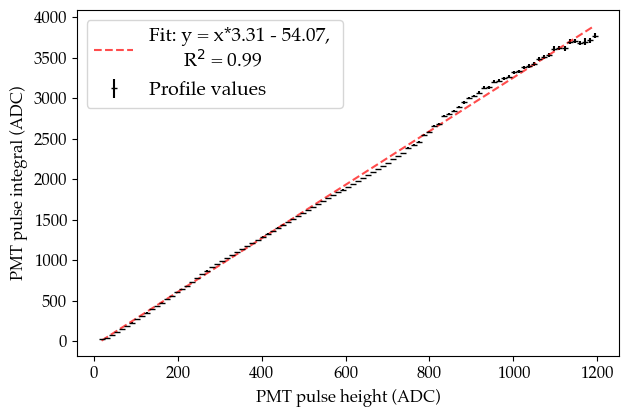

(3.3093056315833635, -54.07281558981299)

In [17]:
linear_fit(x, y, yu)

## Fit all dates

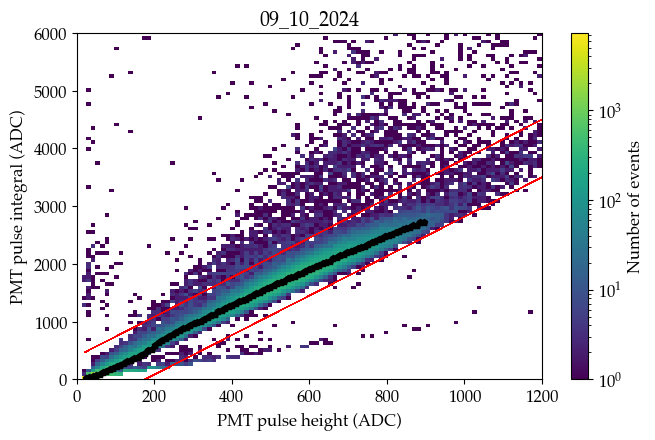

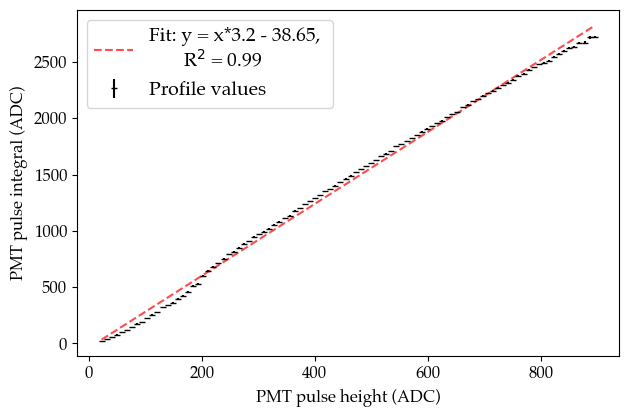

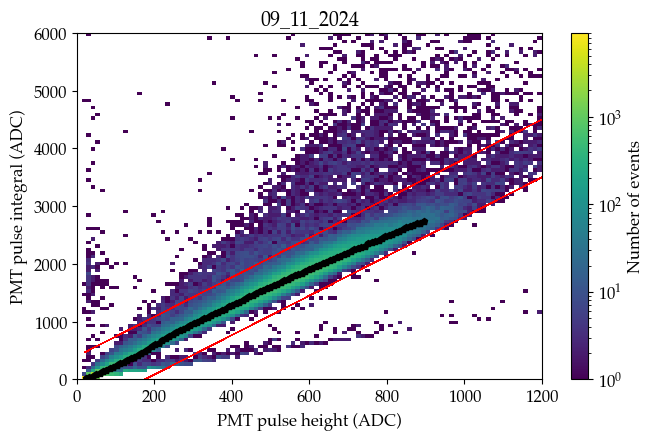

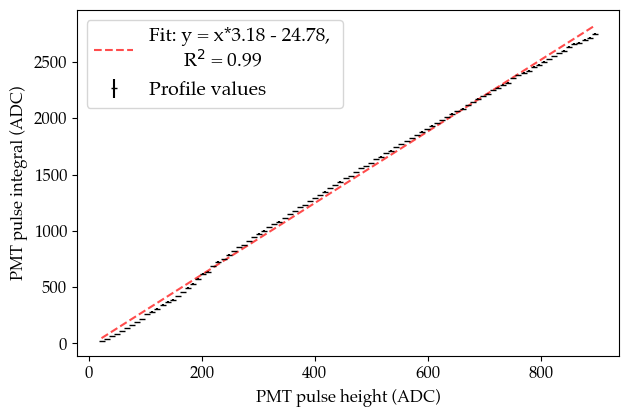

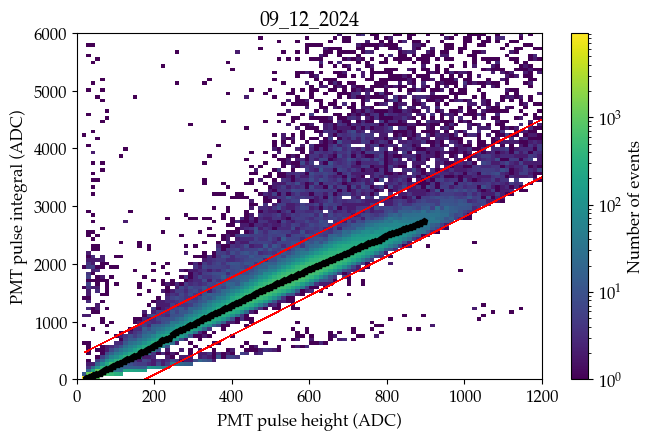

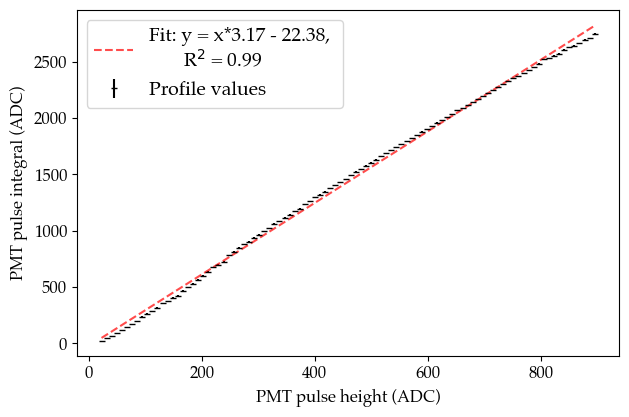

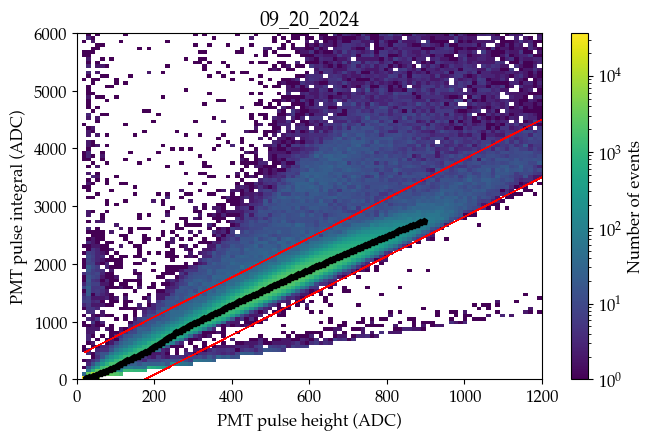

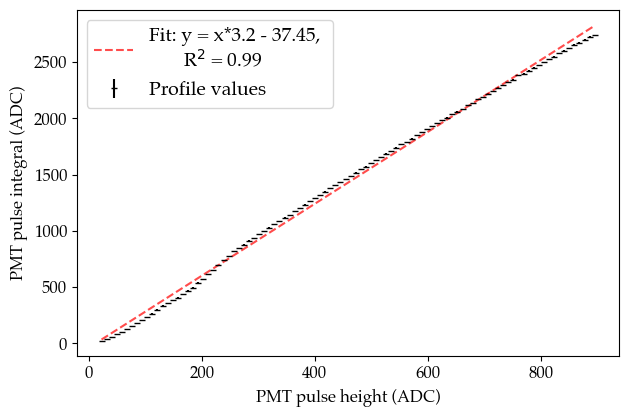

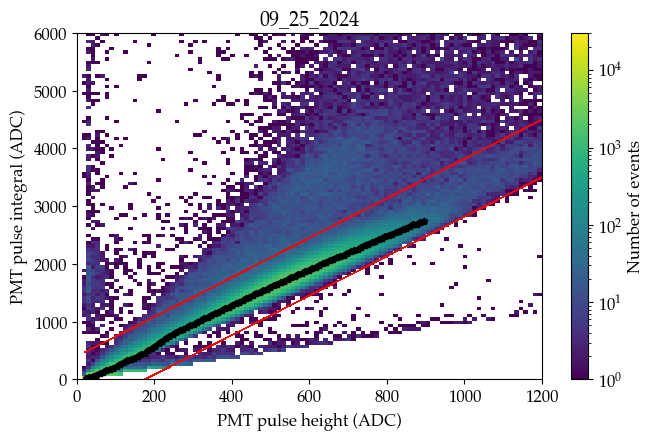

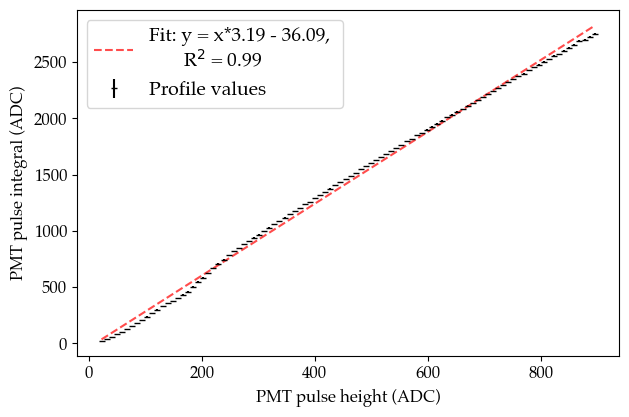

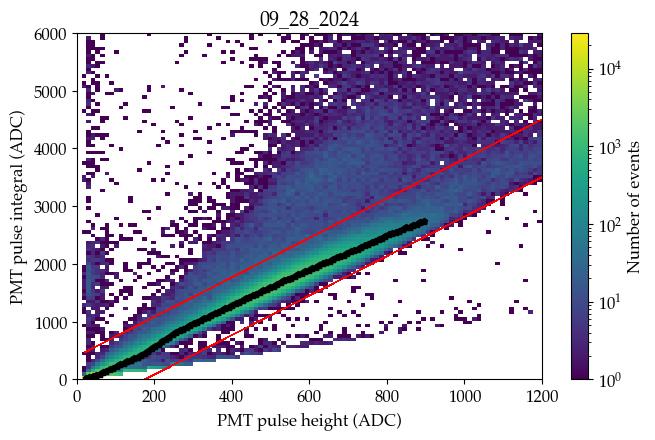

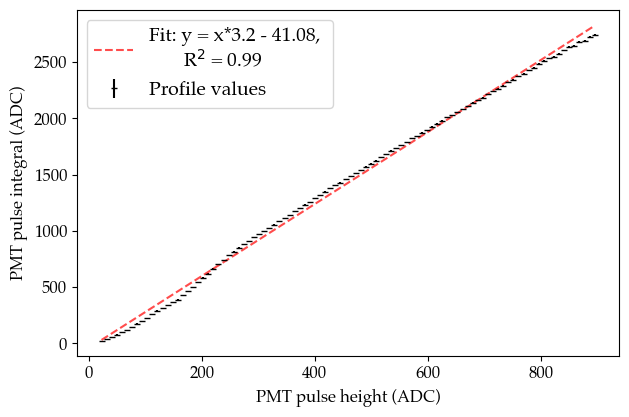

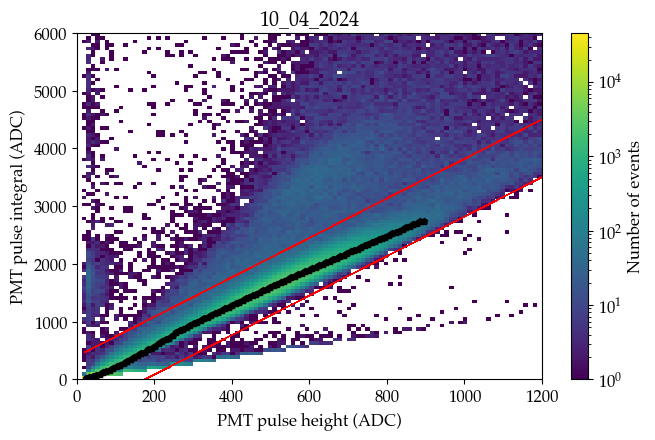

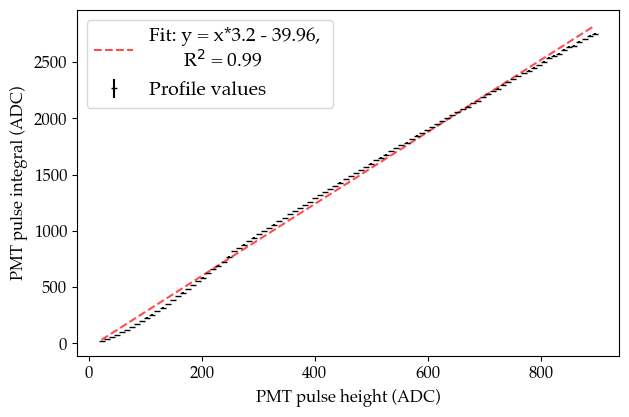

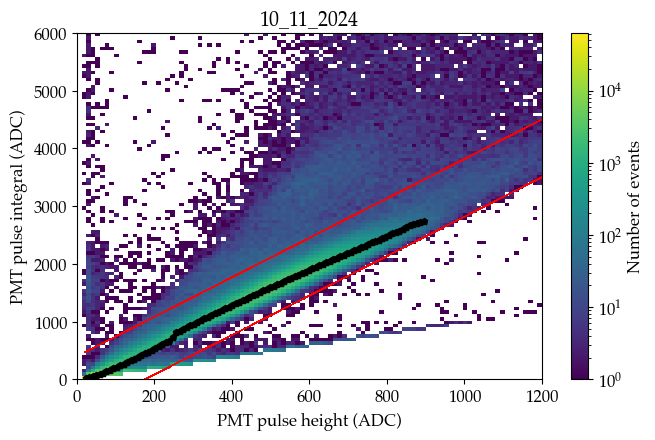

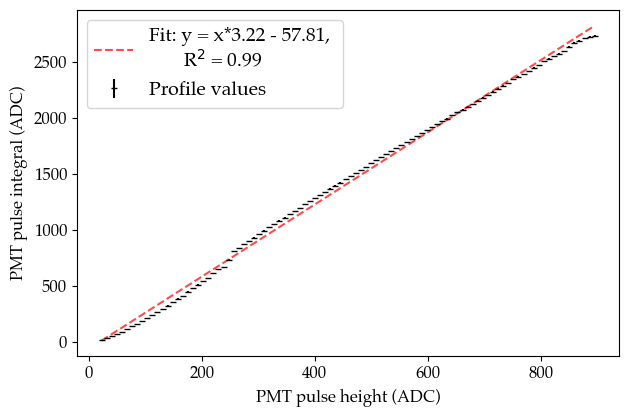

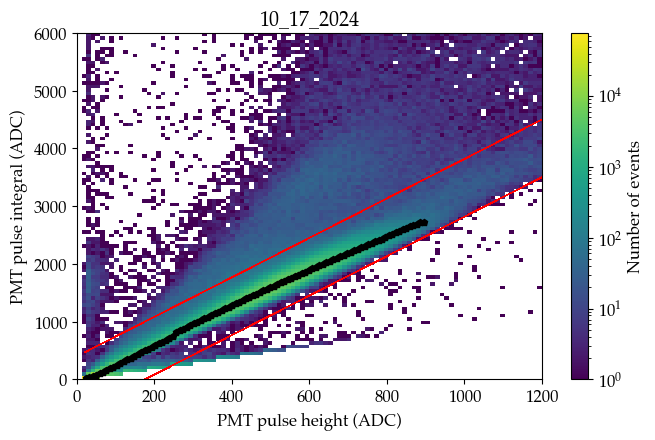

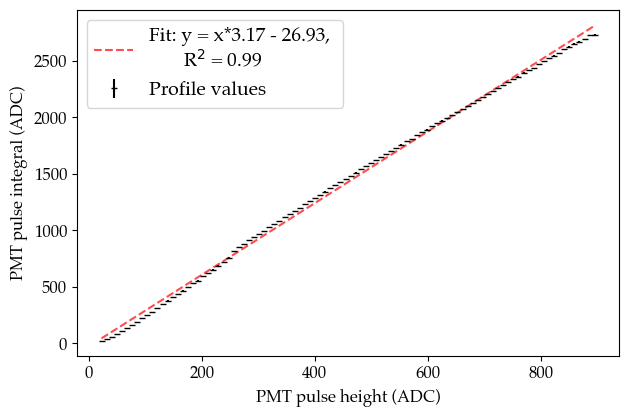

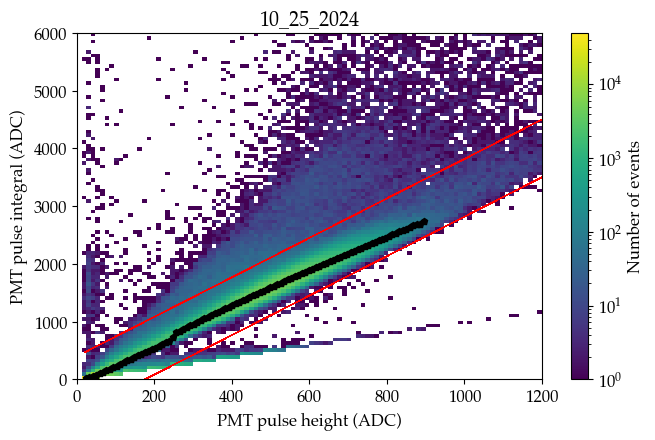

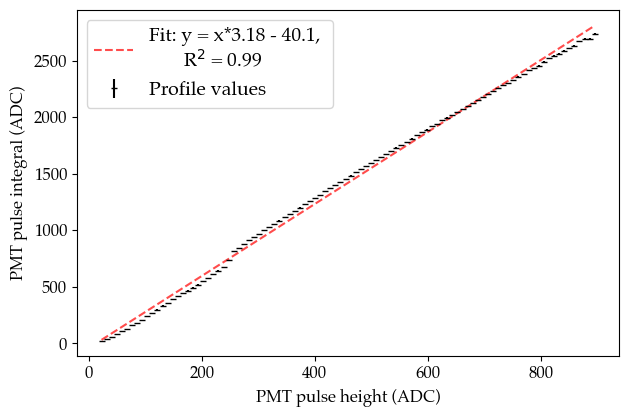

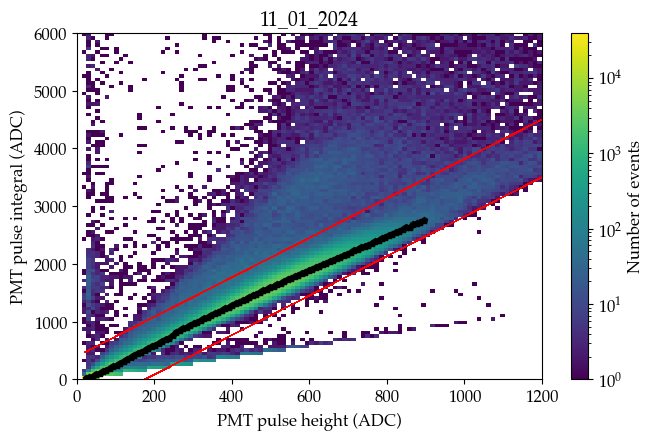

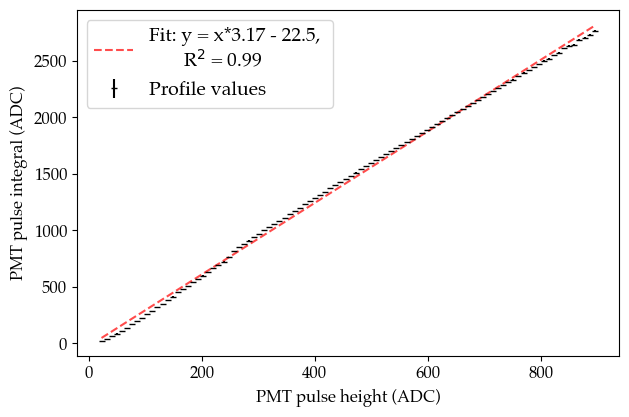

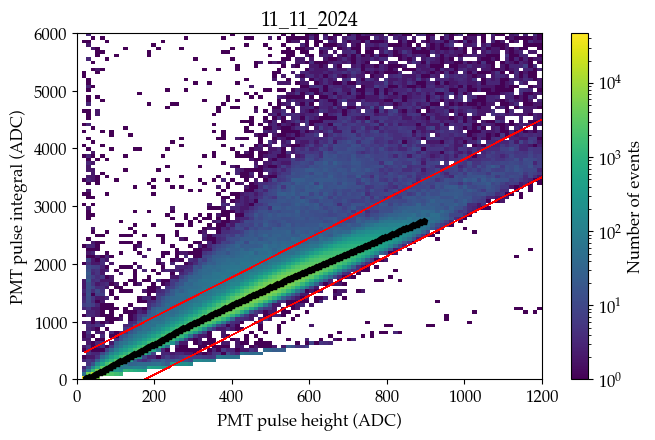

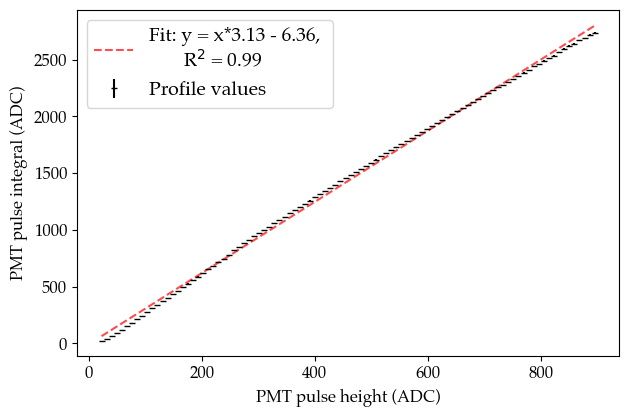

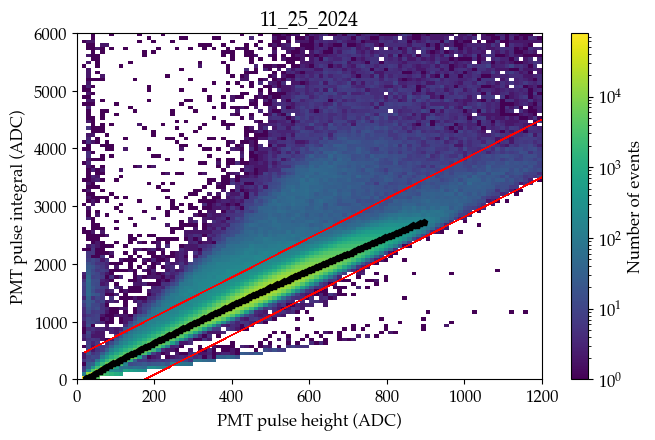

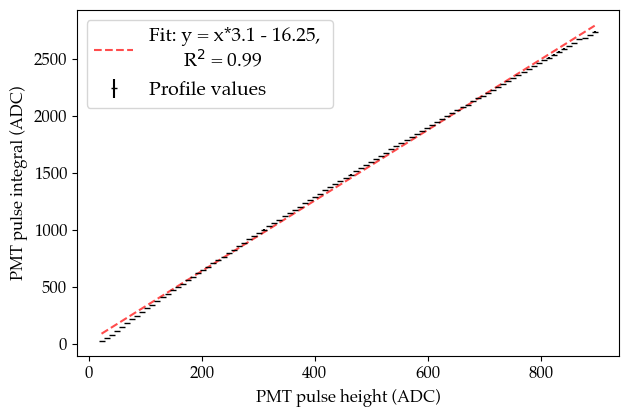

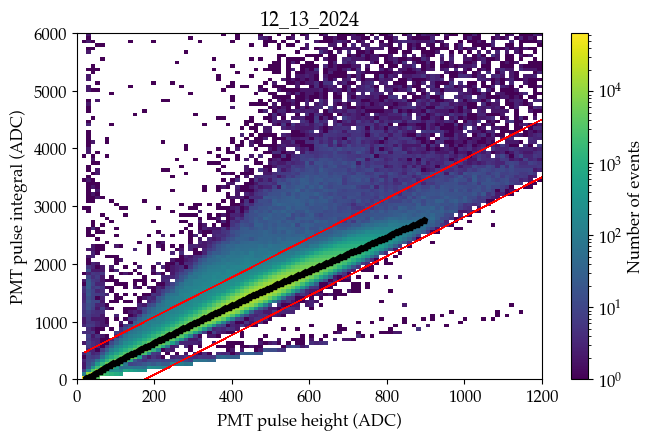

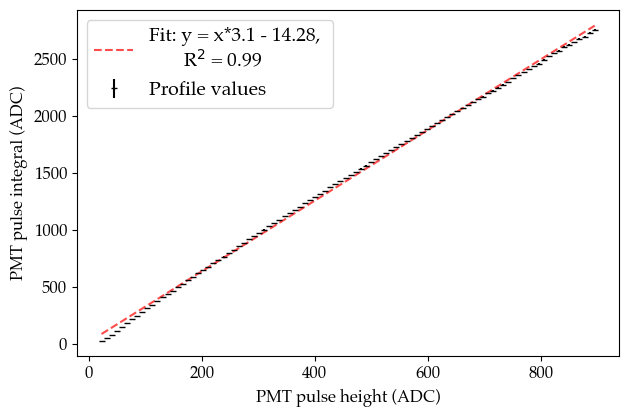

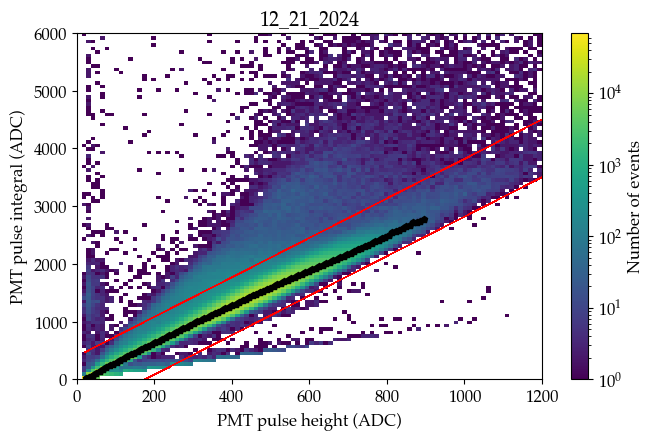

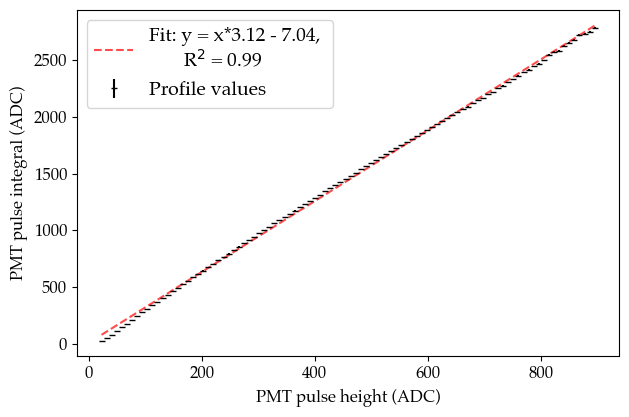

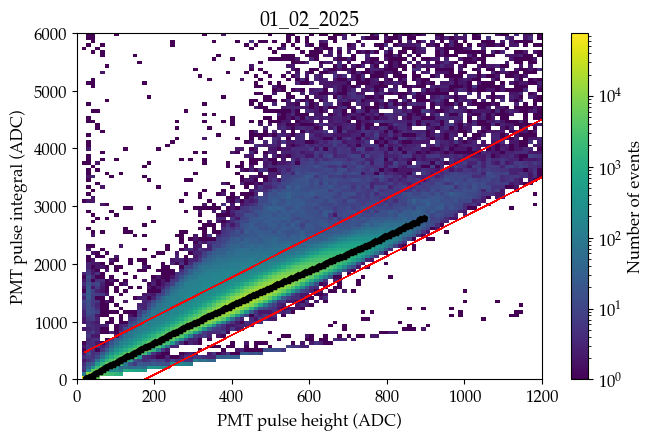

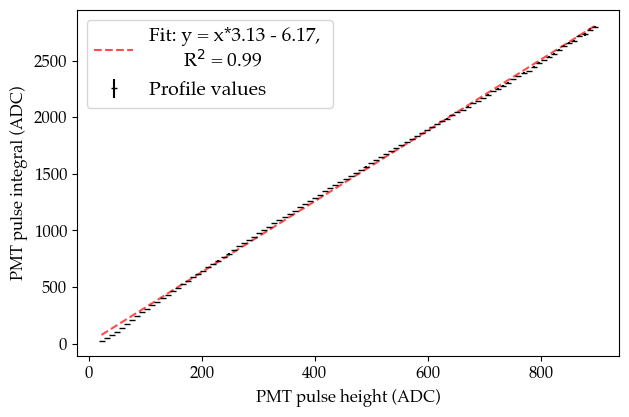

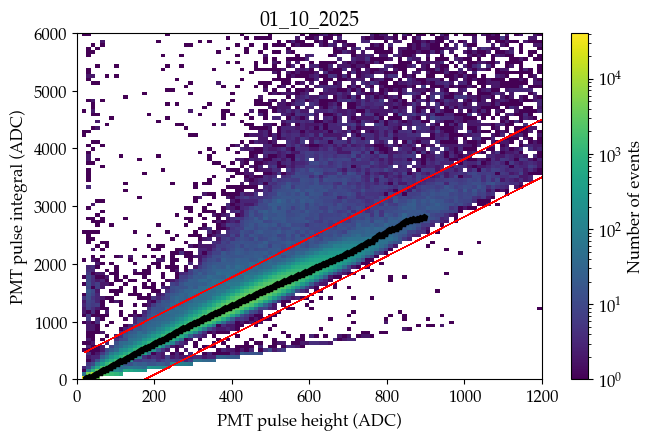

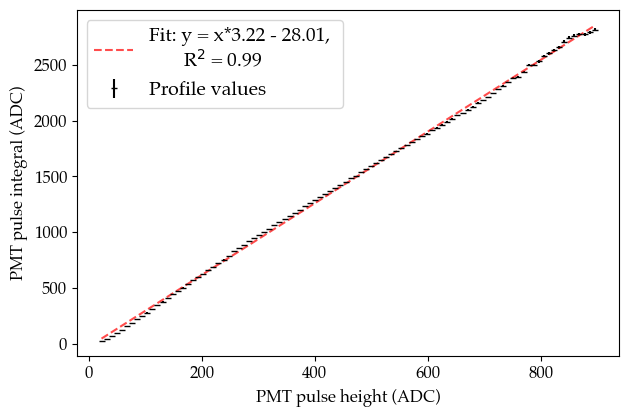

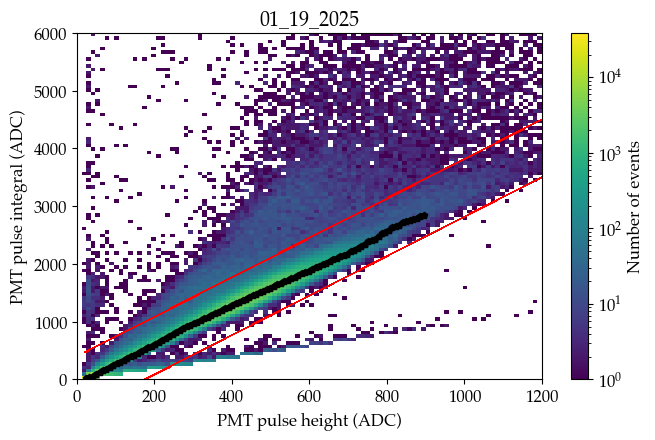

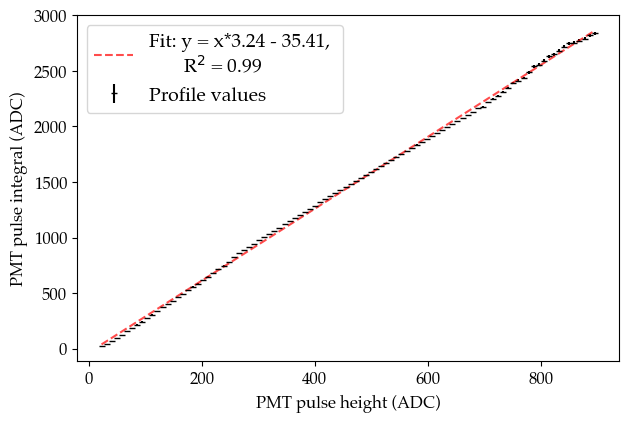

In [18]:
nbins = 100
rng_height = (0,  900)
rng_integ  = (0, 3000)
all_slopes = {}
for date in h_peaks_pmt_dict.keys():
    line_test, line_test2 = make_lines_thr(0, 400, 1200, 4500, h_peaks_pmt_dict[date])
    
    sel_lines = (i_peaks_pmt_dict[date] < (line_test)) & (i_peaks_pmt_dict[date] > (line_test2))
    h_peaks   =  h_peaks_pmt_dict[date][sel_lines]
    i_peaks   =  i_peaks_pmt_dict[date][sel_lines]
    plt.hist2d(h_peaks_pmt_dict[date], i_peaks_pmt_dict[date], (nbins, nbins), range=((0, 1200), (0, 6000)), cmin=1, norm=LogNorm())
    x, y, yu  = fitf2.profileX(h_peaks, i_peaks, nbins, xrange=rng_height, yrange=rng_integ, drop_nan=True)
    plt.errorbar(x, y, yu, np.diff(x)[0]/2, fmt='kp', ms=5, lw=2)
    plt.title(date)
    plt.ylabel('PMT pulse integral (ADC)')
    plt.xlabel('PMT pulse height (ADC)')
    plt.colorbar().set_label('Number of events')
    plt.plot(h_peaks_pmt_dict[date], line_test,  c='r', ls='--', lw=0.5)
    plt.plot(h_peaks_pmt_dict[date], line_test2, c='r', ls='--', lw=0.5)
    plt.show()
    
    slope, intersect = linear_fit(x, y, yu)
    all_slopes[date] = slope

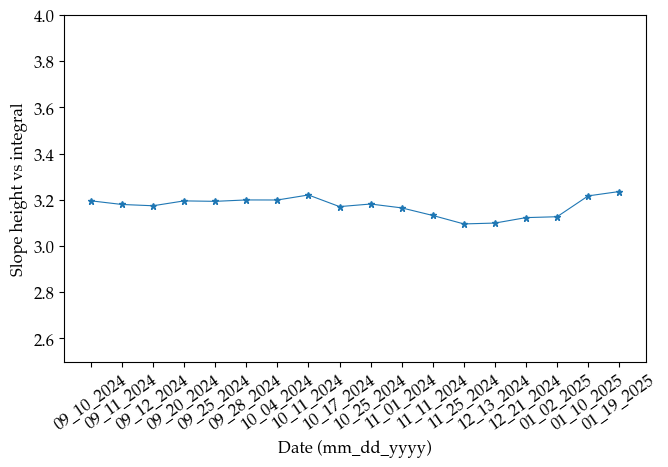

In [19]:
plt.plot(all_slopes.keys(), all_slopes.values(), lw=0.8, marker='*', markersize=5)
plt.xticks(rotation=35)
plt.ylim(2.5, 4)
plt.xlabel('Date (mm_dd_yyyy)')
plt.ylabel('Slope height vs integral')
plt.show()

## Why some dates have the hist2d less clean?

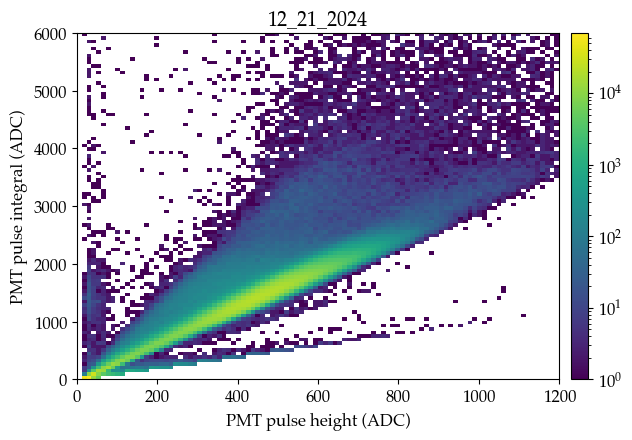

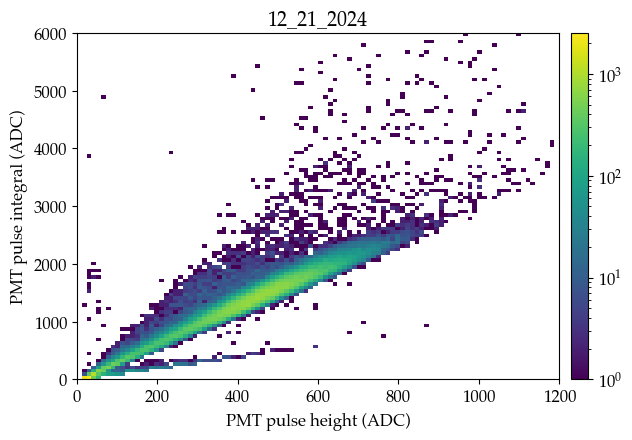

In [20]:
sel_date = '12_21_2024'
plt.hist2d(h_peaks_pmt_dict[sel_date], i_peaks_pmt_dict[sel_date], bins=(100, 100), range=((0, 1200), (0, 6000)), cmin=1, norm=LogNorm())
plt.ylabel('PMT pulse integral (ADC)')
plt.xlabel('PMT pulse height (ADC)')
plt.title(f'{sel_date}')
plt.colorbar(pad=0.02)
plt.show()

sel_date = '12_21_2024'
plt.hist2d(h_peaks_pmt_dict[sel_date][100000:200000], i_peaks_pmt_dict[sel_date][100000:200000], bins=(100, 100), range=((0, 1200), (0, 6000)), cmin=1, norm=LogNorm())
plt.ylabel('PMT pulse integral (ADC)')
plt.xlabel('PMT pulse height (ADC)')
plt.title(f'{sel_date}')
plt.colorbar(pad=0.02)
plt.show()

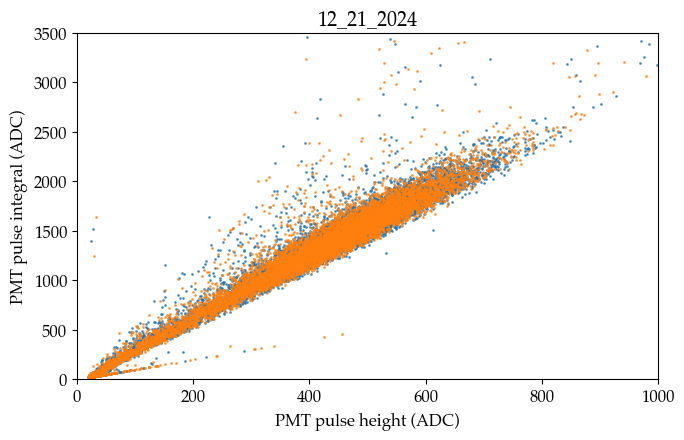

In [21]:
sel_date = '12_21_2024'
plt.scatter(h_peaks_pmt_dict[sel_date][0    :10000], i_peaks_pmt_dict[sel_date][0    :10000], s=1, alpha=0.7)
plt.scatter(h_peaks_pmt_dict[sel_date][-10000:    ], i_peaks_pmt_dict[sel_date][-10000:    ], s=1, alpha=0.7)
plt.ylabel('PMT pulse integral (ADC)')
plt.xlabel('PMT pulse height (ADC)')
plt.title(f'{sel_date}')
plt.xlim(0, 1000)
plt.ylim(0, 3500)
plt.show()

## Try to look for bad waveforms

In [90]:
def check_saturation(waveform, max_thr):
    if np.max(waveform) >= max_thr:
        return True  # Saturated waveform
    return False

def check_ringing(wf, thr=0.1):
    # Compute the first derivative of the waveform
    diff_wf = np.diff(wf)
    # Look for oscillations based on the derivative exceeding a threshold
    oscillations = np.sum(np.abs(diff_wf) > thr)
    if oscillations > 2:  # Some threshold for "too many oscillations"
        return True  # Ringing detected
    return False

def check_snr(wf, bsl_region=(0, 650)):
    bsl       = wf[bsl_region[0]:bsl_region[1]]
    noise_std = np.std(bsl)
    peak      = np.max(wf)
    snr       = peak / noise_std
    if snr < some_threshold:  # Threshold for low SNR
        return True  # Bad waveform
    return False

from scipy.signal import correlate

def check_template_match(wf, template, thr=0.8):
    correlation = np.max(correlate(wf, template))
    if correlation < thr:
        return True  # Bad waveform
    return False

def check_outlier(waveform, mean_peak_height, std_peak_height, thr=3):
    peak_height = np.max(waveform)
    if np.abs(peak_height - mean_peak_height) > thr * std_peak_height:
        return True  # Outlier detected
    return False

def identify_bad_waveform(wf, max_thr, bsl_region):
    if check_saturation(wf, max_thr):
        return True
    if check_ringing(wf):
        return True
    if check_snr(wf, bsl_region):
        return True
    #if check_template_match(wf, template):
    #    return True
    #if check_outlier(wf, mean_peak_height, std_peak_height):
    #    return True
    return False

In [87]:
filename = '/Users/romoluque_c/LEGEND/BACON/new_setup/datatest/run-11_25_2024-file.root'
infile   = uproot.open(filename)
RawTree  = infile['RawTree']

ch           = 12
thr_ADC_pmt  = 20
min_dist_pmt = 15
max_smpl_bsl = 650
std_thr_dict = {0: 13, 1: 13, 2: 13, 3: 13, 4: 14, 5: 13, 6: 12, 7: 13, 8: 13, 9: 30, 10: 40, 11: 40, 12:  4}
wfs          = pf.wfs_from_rawtree(RawTree, ch)
swfs         = np.array([blr.pmt_deconvolver(wf, wf_range_bsl=(0, max_smpl_bsl), baseline_mode=False, std_lim=3*std_thr_dict[ch]) for wf in wfs])

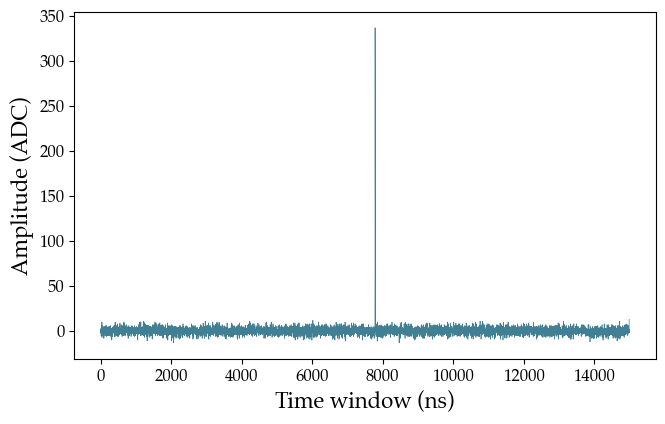

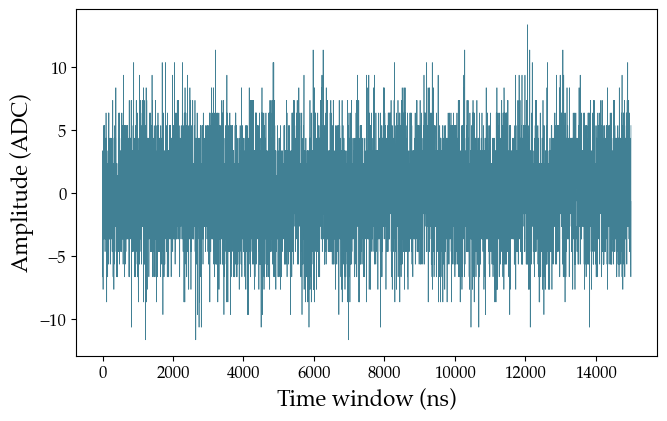

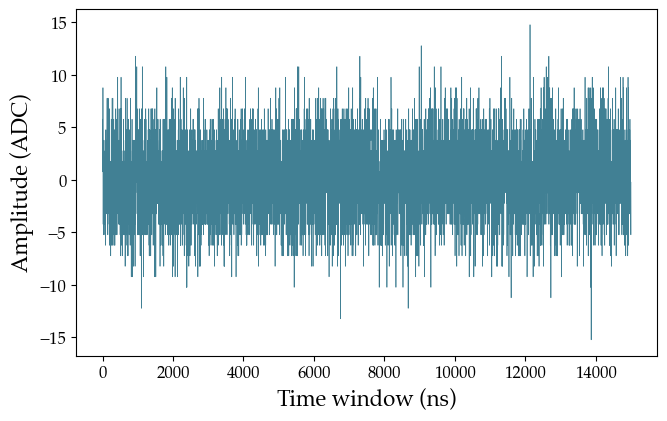

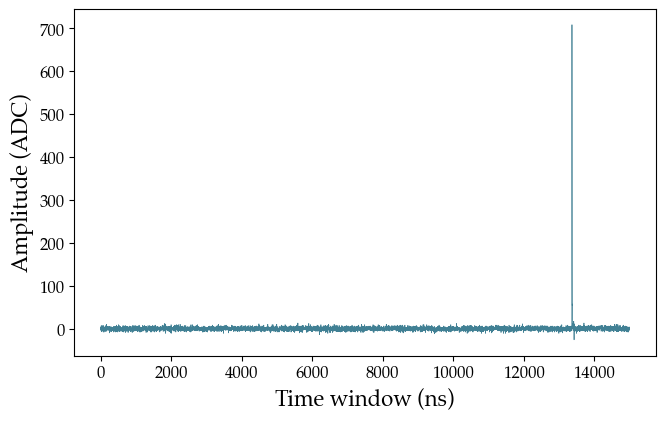

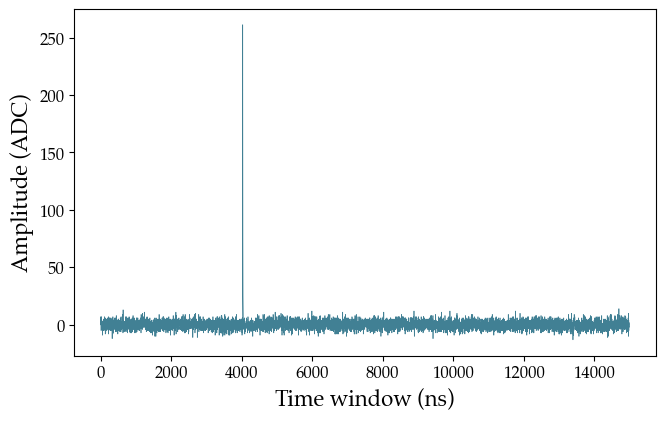

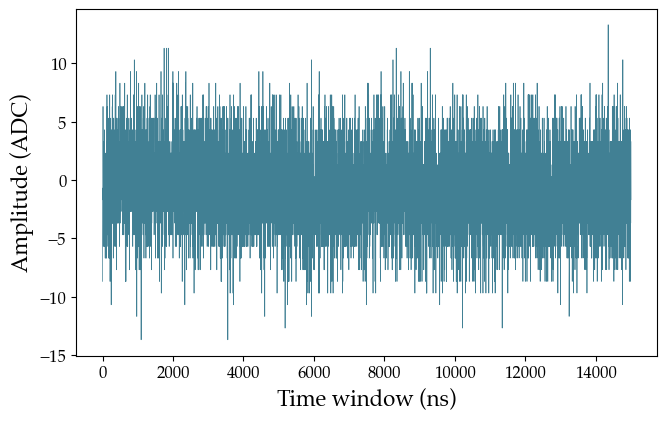

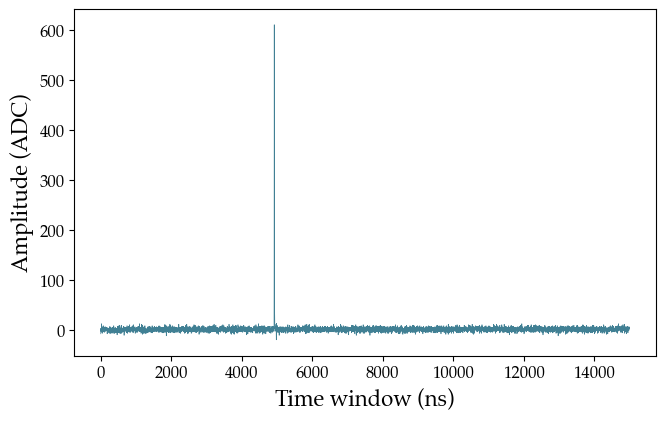

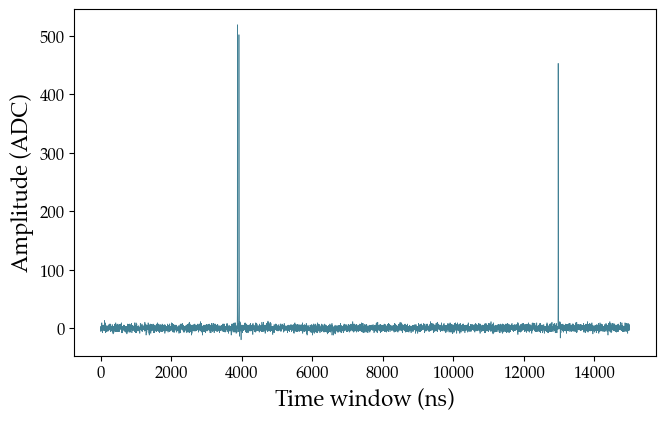

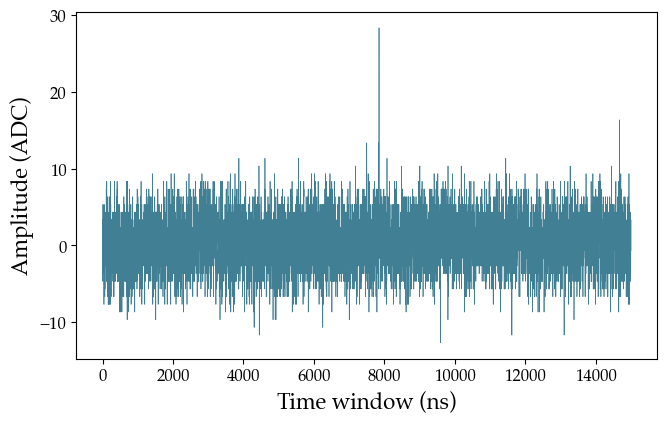

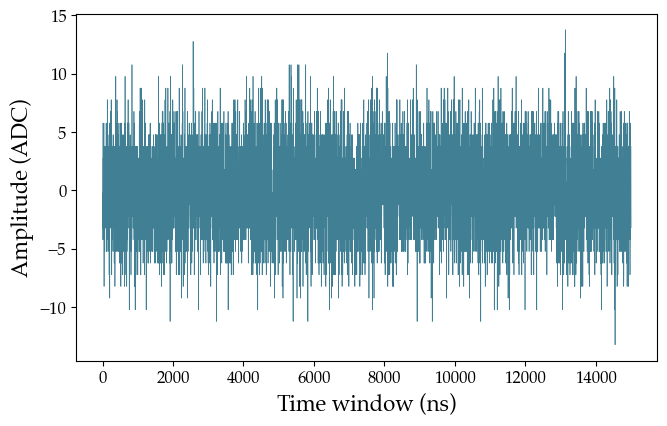

In [93]:
bad_wfs = []
for wf in swfs[:10]:
    if identify_bad_waveform(wf, max_thr=5000, bsl_region=(0, 650)):
        #bad_wfs.append(wf)
        plt.plot(2*np.arange(len(wf)), wf, lw=0.5, c=fav_col)
        plt.xlabel('Time window (ns)', fontsize=16)
        plt.ylabel('Amplitude (ADC)',  fontsize=16)
        #plt.savefig(f'/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/pmt_bad_evt_{i}.pdf', dpi=300, bbox_inches='tight')
        plt.show()
